In [1]:
#Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
import seaborn as sns
import os

import matplotlib.dates as mdates

import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, ParameterGrid
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from prophet import Prophet
from prophet.diagnostics import performance_metrics, cross_validation

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## I'll be working with the Metro Nashville Police Department Service Calls from 2017-2024. The data is broken up into different tables by year. This is an open - ended analysis and our only constraint is a 4 hour time limit. Given the time constraint, I will be limiting my analysis to officer and resource allocation given past service calls and Time Series Analysis to predict future service calls.

In [2]:
df_2024 = pd.read_csv('../raw_data/Metro_Nashville_PD_Calls_2024.csv', dtype={17: str})

In [3]:
df_2024.head()

,OBJECTID,Event Number,Complaint Number,Tencode,Tencode Description,Tencode Suffix,Tencode Suffix Description,Disposition Code,Disposition Description,Block,Street Name,Unit Dispatched,Shift,Sector,Mapped Location,POINT_X,POINT_Y,Zone,Latitude,Longitude,RPA,Call Received,x,y
0,1,PD202400492222,NaN,65,DANGEROUS / INJURED ANIMAL,P,PROGRESS,11,DISREGARD / SIGNAL 9,800.0,LEMONT DR,NaN,B,231,NaN,NaN,NaN,225,NaN,NaN,1841.0,6/19/2024 8:25:38 PM,NaN,NaN
1,2,PD202400294388,NaN,70,BURGLARY - RESIDENCE,P,PROGRESS,11,DISREGARD / SIGNAL 9,NaN,NaN,820A,A,MT,NaN,NaN,NaN,827,NaN,NaN,8651.0,4/12/2024 9:48:14 AM,NaN,NaN
2,3,PD202400519980,NaN,50,THEFT,TV,NaN,5,GONE ON ARRIVAL,900.0,BUCHANAN ST,613C,C,613,NaN,NaN,NaN,611,NaN,NaN,4451.0,6/29/2024 3:11:08 AM,NaN,NaN
3,4,PD202400178239,2.024015e+10,44,DISORDERLY PERSON,P,PROGRESS,1,M.P.D. REPORT COMPLED,NaN,NaN,315B,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3/3/2024 7:36:04 PM,NaN,NaN
4,5,PD202400679437,NaN,93,TRAFFIC VIOLATION,NaN,NaN,3M,NaN,NaN,MCFERRIN AVE,227A,A,EAST,NaN,NaN,NaN,221,36.192,-86.753,1903.0,8/24/2024 7:55:39 AM,-9.657300e+06,4.327073e+06


In [4]:
df_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279874 entries, 0 to 279873
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   OBJECTID                    279874 non-null  int64  
 1   Event Number                279874 non-null  object 
 2   Complaint Number            46549 non-null   float64
 3   Tencode                     279874 non-null  int64  
 4   Tencode Description         257311 non-null  object 
 5   Tencode Suffix              221094 non-null  object 
 6   Tencode Suffix Description  184471 non-null  object 
 7   Disposition Code            277824 non-null  object 
 8   Disposition Description     251491 non-null  object 
 9   Block                       177945 non-null  float64
 10  Street Name                 213272 non-null  object 
 11  Unit Dispatched             250262 non-null  object 
 12  Shift                       279874 non-null  object 
 13  Sector        

In [5]:
#Checking for duplicates
duplicates = df_2024[df_2024.duplicated()]
print(duplicates)

Empty DataFrame
Columns: [OBJECTID, Event Number, Complaint Number, Tencode, Tencode Description, Tencode Suffix, Tencode Suffix Description, Disposition Code, Disposition Description, Block, Street Name, Unit Dispatched, Shift, Sector, Mapped Location, POINT_X, POINT_Y, Zone, Latitude, Longitude, RPA, Call Received, x, y]
Index: []


In [6]:
#Missing every value from POINT_X & POINT_Y. Confirmed with original data source that this data is not given.
#Mapped Location is also not in original dataset and is missing every value
#OBJECTID is being dropped, data is already zero indexed
#Complaint Number is a near duplicate to Event Number w/o leading 'PD'
#Latitude and Longitude are not relevant to our analysis and are being dropped
#x and y are not in original dataset but seem to correspond to Lat & Long as they are missing in the same observations so are being dropped
#Tencode Suffix and Tencode Suffix Description are descriptors of Tencode and do not add sufficient detail to the analysis being done today
df_2024.drop(columns=['Event Number', 'Tencode Suffix', 'Tencode Suffix Description', 'Disposition Code', 'Disposition Description',
                      'Complaint Number', 'POINT_X', 'POINT_Y','Mapped Location', 'Latitude', 'Longitude', 'OBJECTID', 'x', 'y',
                      'Unit Dispatched', 'RPA'], inplace=True)

In [7]:
column_mapping = {
    'Tencode Description': 'Tencode_Description',
    'Street Name': 'Street_Name',
    'Call Received': 'Call_Received'}

df_2024.rename(columns=column_mapping, inplace=True)

In [8]:
df_2024.head()

,Tencode,Tencode_Description,Block,Street_Name,Shift,Sector,Zone,Call_Received
0,65,DANGEROUS / INJURED ANIMAL,800.0,LEMONT DR,B,231,225,6/19/2024 8:25:38 PM
1,70,BURGLARY - RESIDENCE,NaN,NaN,A,MT,827,4/12/2024 9:48:14 AM
2,50,THEFT,900.0,BUCHANAN ST,C,613,611,6/29/2024 3:11:08 AM
3,44,DISORDERLY PERSON,NaN,NaN,B,NaN,NaN,3/3/2024 7:36:04 PM
4,93,TRAFFIC VIOLATION,NaN,MCFERRIN AVE,A,EAST,221,8/24/2024 7:55:39 AM


In [9]:
df_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279874 entries, 0 to 279873
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Tencode              279874 non-null  int64  
 1   Tencode_Description  257311 non-null  object 
 2   Block                177945 non-null  float64
 3   Street_Name          213272 non-null  object 
 4   Shift                279874 non-null  object 
 5   Sector               159876 non-null  object 
 6   Zone                 209733 non-null  object 
 7   Call_Received        279874 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 17.1+ MB


In [10]:
df_2023 = pd.read_csv('../raw_data/Metro_Nashville_PD_Calls_2023.csv', dtype={14: str})

In [11]:
df_2023.head()

,OBJECTID,Event_Number,Complaint_Number,Tencode,Tencode_Description,Tencode_Suffix,Tencode_Suffix_Description,Disposition_Code,Disposition_Description,Block,Street_name,Unit_Dispatched,Shift,Sector,ZONE_,Latitude,Longitude,RPA,Call_Received,x,y
0,1,PD202300794205,NaN,88,INVESTIGATE 911 HANG-UP CALL,PW,NaN,4,ASSISTED CITIZEN,2500.0,DAVID DR,511A,A,517,517,NaN,NaN,9113.0,10/30/2023 12:52:30 PM,NaN,NaN
1,2,PD202300562586,2.023046e+10,43,WANT OFFICER FOR INVESTIGATION / ASSISTA,P,PROGRESS,10,NO RESPONSE,NaN,NaN,113A,A,NaN,NaN,NaN,NaN,NaN,8/5/2023 2:42:40 PM,NaN,NaN
2,3,PD202300121072,NaN,50,THEFT,RV,NaN,10,NO RESPONSE,300.0,TRAILS CIR,533B,B,533,533,NaN,NaN,8957.0,2/17/2023 9:45:20 PM,NaN,NaN
3,4,PD202300886771,NaN,70,BURGLARY - RESIDENCE,A,ALARM,11,DISREGARD / SIGNAL 9,600.0,CHELMSFORD PL,NaN,A,127,113,NaN,NaN,6103.0,12/4/2023 1:45:48 PM,NaN,NaN
4,5,PD202300170942,NaN,43,WANT OFFICER FOR INVESTIGATION / ASSISTA,P,PROGRESS,5,GONE ON ARRIVAL,100.0,COLEMONT CT,325C,B,333,323,NaN,NaN,8713.0,3/9/2023 4:20:06 AM,NaN,NaN


In [12]:
#Checking for duplicates
duplicates = df_2023[df_2023.duplicated()]
print(duplicates)

Empty DataFrame
Columns: [OBJECTID, Event_Number, Complaint_Number, Tencode, Tencode_Description, Tencode_Suffix, Tencode_Suffix_Description, Disposition_Code, Disposition_Description, Block, Street_name, Unit_Dispatched, Shift, Sector, ZONE_, Latitude, Longitude, RPA, Call_Received, x, y]
Index: []


In [13]:
#OBJECTID is being dropped, data is already zero indexed
#Complaint Number is a near duplicate to Event Number w/o leading 'PD'
#Latitude and Longitude are not relevant to our analysis and are being dropped
#x and y are not in original dataset but seem to correspond to Lat & Long as they are missing in the same observations so are being dropped
#Tencode Suffix and Tencode Suffix Description are descriptors of Tencode and do not add sufficient detail to the analysis being done today
df_2023.drop(columns=['OBJECTID', 'Event_Number', 'Complaint_Number', 'Tencode_Suffix', 'Tencode_Suffix_Description', 'Disposition_Code',
                 'Disposition_Description', 'Unit_Dispatched', 'Latitude', 'Longitude', 'RPA', 'x', 'y'], inplace=True)

In [14]:
#Match columns of df_2024
column_mapping = {
    'Street_name': 'Street_Name',
    'ZONE_': 'Zone'}

df_2023.rename(columns=column_mapping, inplace=True)

In [15]:
df_2023.head()

,Tencode,Tencode_Description,Block,Street_Name,Shift,Sector,Zone,Call_Received
0,88,INVESTIGATE 911 HANG-UP CALL,2500.0,DAVID DR,A,517,517,10/30/2023 12:52:30 PM
1,43,WANT OFFICER FOR INVESTIGATION / ASSISTA,NaN,NaN,A,NaN,NaN,8/5/2023 2:42:40 PM
2,50,THEFT,300.0,TRAILS CIR,B,533,533,2/17/2023 9:45:20 PM
3,70,BURGLARY - RESIDENCE,600.0,CHELMSFORD PL,A,127,113,12/4/2023 1:45:48 PM
4,43,WANT OFFICER FOR INVESTIGATION / ASSISTA,100.0,COLEMONT CT,B,333,323,3/9/2023 4:20:06 AM


In [16]:
df_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444026 entries, 0 to 444025
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Tencode              444026 non-null  int64  
 1   Tencode_Description  412752 non-null  object 
 2   Block                278570 non-null  float64
 3   Street_Name          334057 non-null  object 
 4   Shift                444026 non-null  object 
 5   Sector               254366 non-null  object 
 6   Zone                 334086 non-null  object 
 7   Call_Received        444026 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 27.1+ MB


In [17]:
df_2022 = pd.read_csv('../raw_data/Metro_Nashville_PD_Calls_2022.csv', dtype={14: str})

In [18]:
df_2022.head()

,OBJECTID,Event_Number,Complaint_Number,Tencode,Tencode_Description,Tencode_Suffix,Tencode_Suffix_Description,Disposition_Code,Disposition_Description,Block,Street_name,Unit_Dispatched,Shift,Sector,ZONE_,Latitude,Longitude,RPA,Call_Received,x,y
0,1,PD202200451635,2.022036e+10,50,THEFT,R,REPORT,1,M.P.D. REPORT COMPLED,NaN,NaN,525B,B,NaN,NaN,NaN,NaN,NaN,7/24/2022 11:44:55 PM,NaN,NaN
1,2,PD202200630817,NaN,93,TRAFFIC VIOLATION,NaN,NaN,9T,NaN,3100.0,DICKERSON PIKE,211B,C,NaN,225,36.230,-86.759,1807.0,10/10/2022 5:38:25 AM,-86.759,36.230
2,3,PD202200445386,2.022036e+10,50,THEFT,TV,NaN,1,M.P.D. REPORT COMPLED,100.0,ARBOR KNOLL BLVD,715B,B,NaN,333,36.042,-86.668,8753.0,7/21/2022 11:39:37 PM,-86.668,36.042
3,4,PD202200299563,NaN,46,VEHICLE ACCIDENT - PERSONAL INJURY,P,PROGRESS,11,DISREGARD / SIGNAL 9,NaN,AUGUSTA DR,520B,B,523,525,36.212,-86.594,9537.0,5/17/2022 11:43:32 PM,-86.594,36.212
4,5,PD202200593226,NaN,87,SAFETY HAZARD,P,PROGRESS,NaN,NaN,NaN,CENTRAL PIKE,NaN,B,521,525,36.188,-86.634,9601.0,9/24/2022 2:56:14 AM,-86.634,36.188


In [19]:
#Checking for duplicates
duplicates = df_2022[df_2022.duplicated()]
print(duplicates)

Empty DataFrame
Columns: [OBJECTID, Event_Number, Complaint_Number, Tencode, Tencode_Description, Tencode_Suffix, Tencode_Suffix_Description, Disposition_Code, Disposition_Description, Block, Street_name, Unit_Dispatched, Shift, Sector, ZONE_, Latitude, Longitude, RPA, Call_Received, x, y]
Index: []


In [20]:
#OBJECTID is being dropped, data is already zero indexed
#Complaint Number is a near duplicate to Event Number w/o leading 'PD'
#Latitude and Longitude are not relevant to our analysis and are being dropped
#x and y are not in original dataset but seem to correspond to Lat & Long as they are missing in the same observations so are being dropped
#Tencode Suffix and Tencode Suffix Description are descriptors of Tencode and do not add sufficient detail to the analysis being done today
df_2022.drop(columns=['OBJECTID', 'Event_Number', 'Complaint_Number', 'Tencode_Suffix', 'Tencode_Suffix_Description', 'Disposition_Code',
                 'Disposition_Description', 'Unit_Dispatched', 'Latitude', 'Longitude', 'RPA', 'x', 'y'], inplace=True)

In [21]:
#Match columns of df_2024
column_mapping = {
    'Street_name': 'Street_Name',
    'ZONE_': 'Zone'}

df_2022.rename(columns=column_mapping, inplace=True)

In [22]:
df_2022.head()

,Tencode,Tencode_Description,Block,Street_Name,Shift,Sector,Zone,Call_Received
0,50,THEFT,NaN,NaN,B,NaN,NaN,7/24/2022 11:44:55 PM
1,93,TRAFFIC VIOLATION,3100.0,DICKERSON PIKE,C,NaN,225,10/10/2022 5:38:25 AM
2,50,THEFT,100.0,ARBOR KNOLL BLVD,B,NaN,333,7/21/2022 11:39:37 PM
3,46,VEHICLE ACCIDENT - PERSONAL INJURY,NaN,AUGUSTA DR,B,523,525,5/17/2022 11:43:32 PM
4,87,SAFETY HAZARD,NaN,CENTRAL PIKE,B,521,525,9/24/2022 2:56:14 AM


In [23]:
df_2021 = pd.read_csv('../raw_data/Metro_Nashville_PD_Calls_2021.csv', dtype={14: str})

In [24]:
df_2021.head()

,OBJECTID,Event_Number,Complaint_Number,Tencode,Tencode_Description,Tencode_Suffix,Tencode_Suffix_Description,Disposition_Code,Disposition_Description,Block,Street_name,Unit_Dispatched,Shift,Sector,ZONE_,Latitude,Longitude,RPA,Call_Received,x,y
0,1,PD202100507386,2.021042e+10,43,WANT OFFICER FOR INVESTIGATION / ASSISTA,RT,NaN,1,M.P.D. REPORT COMPLED,NaN,NaN,TE16,B,NaN,NaN,NaN,NaN,NaN,8/9/2021 10:21:07 PM,NaN,NaN
1,2,PD202100266861,NaN,45,VEHICLE ACCIDENT - PROPERTY DAMAGE,P,PROGRESS,6,ASSISTED OTHER UNIT,700.0,MITCHELL AVE,630A,A,NaN,NaN,NaN,NaN,NaN,4/24/2021 12:22:19 PM,NaN,NaN
2,3,PD202100110057,NaN,43,WANT OFFICER FOR INVESTIGATION / ASSISTA,P,PROGRESS,4,ASSISTED CITIZEN,100.0,ARBOR KNOLL BLVD,333C,C,NaN,333,36.042,-86.668,8753.0,2/17/2021 8:30:32 AM,-86.668,36.042
3,4,PD202100112628,NaN,43,WANT OFFICER FOR INVESTIGATION / ASSISTA,P,PROGRESS,15,COMMUNITY POLICING,500.0,OAKDALE DR,6E14,A,NaN,NaN,NaN,NaN,NaN,2/18/2021 1:13:05 PM,NaN,NaN
4,5,PD202100113407,NaN,43,WANT OFFICER FOR INVESTIGATION / ASSISTA,P,PROGRESS,4,ASSISTED CITIZEN,500.0,OAKDALE DR,6E14,B,NaN,NaN,NaN,NaN,NaN,2/18/2021 9:31:27 PM,NaN,NaN


In [25]:
#Checking for duplicates
duplicates = df_2021[df_2021.duplicated()]
print(duplicates)

Empty DataFrame
Columns: [OBJECTID, Event_Number, Complaint_Number, Tencode, Tencode_Description, Tencode_Suffix, Tencode_Suffix_Description, Disposition_Code, Disposition_Description, Block, Street_name, Unit_Dispatched, Shift, Sector, ZONE_, Latitude, Longitude, RPA, Call_Received, x, y]
Index: []


In [26]:
#OBJECTID is being dropped, data is already zero indexed
#Complaint Number is a near duplicate to Event Number w/o leading 'PD'
#Latitude and Longitude are not relevant to our analysis and are being dropped
#x and y are not in original dataset but seem to correspond to Lat & Long as they are missing in the same observations so are being dropped
#Tencode Suffix and Tencode Suffix Description are descriptors of Tencode and do not add sufficient detail to the analysis being done today
df_2021.drop(columns=['OBJECTID', 'Event_Number', 'Complaint_Number', 'Tencode_Suffix', 'Tencode_Suffix_Description', 'Disposition_Code',
                 'Disposition_Description', 'Unit_Dispatched', 'Latitude', 'Longitude', 'RPA', 'x', 'y'], inplace=True)

In [27]:
#Match columns of df_2024
column_mapping = {
    'Street_name': 'Street_Name',
    'ZONE_': 'Zone'}

df_2021.rename(columns=column_mapping, inplace=True)

In [28]:
df_2021.head()

,Tencode,Tencode_Description,Block,Street_Name,Shift,Sector,Zone,Call_Received
0,43,WANT OFFICER FOR INVESTIGATION / ASSISTA,NaN,NaN,B,NaN,NaN,8/9/2021 10:21:07 PM
1,45,VEHICLE ACCIDENT - PROPERTY DAMAGE,700.0,MITCHELL AVE,A,NaN,NaN,4/24/2021 12:22:19 PM
2,43,WANT OFFICER FOR INVESTIGATION / ASSISTA,100.0,ARBOR KNOLL BLVD,C,NaN,333,2/17/2021 8:30:32 AM
3,43,WANT OFFICER FOR INVESTIGATION / ASSISTA,500.0,OAKDALE DR,A,NaN,NaN,2/18/2021 1:13:05 PM
4,43,WANT OFFICER FOR INVESTIGATION / ASSISTA,500.0,OAKDALE DR,B,NaN,NaN,2/18/2021 9:31:27 PM


In [29]:
df_2020 = pd.read_csv('../raw_data/Metro_Nashville_PD_Calls_2020.csv', dtype={14: str})

In [30]:
df_2020.head()

,OBJECTID,Event_Number,Complaint_Number,Tencode,Tencode_Description,Tencode_Suffix,Tencode_Suffix_Description,Disposition_Code,Disposition_Description,Block,Street_name,Unit_Dispatched,Shift,Sector,ZONE_,Latitude,Longitude,RPA,Call_Received,x,y
0,1,PD202000575828,NaN,43,43,P,PROGRESS,6,ASSISTED OTHER UNIT,NaN,NaN,721B,B,M,727,NaN,NaN,1753.0,8/1/2020 12:14:43 AM,NaN,NaN
1,2,PD202000470720,NaN,57,57,P,PROGRESS,11,DISREGARD / SIGNAL 9,NaN,NaN,NaN,B,H,535,NaN,NaN,8929.0,6/17/2020 3:40:48 AM,NaN,NaN
2,3,PD202000690197,NaN,43,43,P,PROGRESS,4,ASSISTED CITIZEN,NaN,NaN,7E73,B,M,727,NaN,NaN,1753.0,9/15/2020 1:47:14 AM,NaN,NaN
3,4,PD202000470737,NaN,43,43,PM,NaN,10,NO RESPONSE,NaN,NaN,520C,B,H,535,NaN,NaN,8929.0,6/17/2020 3:51:43 AM,NaN,NaN
4,5,PD202000688718,NaN,71,71,A,ALARM,13A,NaN,NaN,NaN,725A,A,M,727,NaN,NaN,1753.0,9/14/2020 2:10:13 PM,NaN,NaN


In [31]:
#Checking for duplicates
duplicates = df_2020[df_2020.duplicated()]
print(duplicates)

Empty DataFrame
Columns: [OBJECTID, Event_Number, Complaint_Number, Tencode, Tencode_Description, Tencode_Suffix, Tencode_Suffix_Description, Disposition_Code, Disposition_Description, Block, Street_name, Unit_Dispatched, Shift, Sector, ZONE_, Latitude, Longitude, RPA, Call_Received, x, y]
Index: []


In [32]:
#OBJECTID is being dropped, data is already zero indexed
#Complaint Number is a near duplicate to Event Number w/o leading 'PD'
#Latitude and Longitude are not relevant to our analysis and are being dropped
#x and y are not in original dataset but seem to correspond to Lat & Long as they are missing in the same observations so are being dropped
#Tencode Suffix and Tencode Suffix Description are descriptors of Tencode and do not add sufficient detail to the analysis being done today
df_2020.drop(columns=['OBJECTID', 'Event_Number', 'Complaint_Number', 'Tencode_Suffix', 'Tencode_Suffix_Description', 'Disposition_Code',
                 'Disposition_Description', 'Unit_Dispatched', 'Latitude', 'Longitude', 'RPA', 'x', 'y'], inplace=True)

In [33]:
#Match columns of df_2024
column_mapping = {
    'Street_name': 'Street_Name',
    'ZONE_': 'Zone'}

df_2020.rename(columns=column_mapping, inplace=True)

In [34]:
df_2020.head()

,Tencode,Tencode_Description,Block,Street_Name,Shift,Sector,Zone,Call_Received
0,43,43,NaN,NaN,B,M,727,8/1/2020 12:14:43 AM
1,57,57,NaN,NaN,B,H,535,6/17/2020 3:40:48 AM
2,43,43,NaN,NaN,B,M,727,9/15/2020 1:47:14 AM
3,43,43,NaN,NaN,B,H,535,6/17/2020 3:51:43 AM
4,71,71,NaN,NaN,A,M,727,9/14/2020 2:10:13 PM


In [35]:
df_2019 = pd.read_csv('../raw_data/Metro_Nashville_PD_Calls_2019.csv', dtype={14: str})

In [36]:
df_2019.head()

,OBJECTID,Event_Number,Complaint_Number,Tencode,Tencode_Description,Tencode_Suffix,Tencode_Suffix_Description,Disposition_Code,Disposition_Description,Block,Street_name,Unit_Dispatched,Shift,Sector,ZONE_,Latitude,Longitude,RPA,Call_Received,x,y
0,1,PD201900437385,NaN,96,BUSINESS CHECK,NaN,NaN,12,LOCATION/BUILDING SECURE,NaN,NaN,835C,C,MT,825,NaN,NaN,8619.0,5/18/2019 10:01:15 AM,NaN,NaN
1,2,PD201900444725,NaN,43,WANT OFFICER FOR INVESTIGATION / ASSISTA,P,PROGRESS,4,ASSISTED CITIZEN,NaN,NaN,831B,B,MT,825,NaN,NaN,8619.0,5/21/2019 2:58:32 AM,NaN,NaN
2,3,PD201900324066,NaN,43,WANT OFFICER FOR INVESTIGATION / ASSISTA,P,PROGRESS,15,COMMUNITY POLICING,NaN,NaN,833B,B,MT,825,NaN,NaN,8619.0,4/12/2019 9:31:08 PM,NaN,NaN
3,4,PD201900308964,NaN,96,BUSINESS CHECK,NaN,NaN,12,LOCATION/BUILDING SECURE,NaN,NaN,833C,C,MT,825,NaN,NaN,8619.0,4/8/2019 10:44:50 AM,NaN,NaN
4,5,PD201900468305,NaN,96,BUSINESS CHECK,NaN,NaN,12,LOCATION/BUILDING SECURE,NaN,NaN,833C,C,MT,825,NaN,NaN,8619.0,5/28/2019 10:00:04 AM,NaN,NaN


In [37]:
#Checking for duplicates
duplicates = df_2019[df_2019.duplicated()]
print(duplicates)

Empty DataFrame
Columns: [OBJECTID, Event_Number, Complaint_Number, Tencode, Tencode_Description, Tencode_Suffix, Tencode_Suffix_Description, Disposition_Code, Disposition_Description, Block, Street_name, Unit_Dispatched, Shift, Sector, ZONE_, Latitude, Longitude, RPA, Call_Received, x, y]
Index: []


In [38]:
#OBJECTID is being dropped, data is already zero indexed
#Complaint Number is a near duplicate to Event Number w/o leading 'PD'
#Latitude and Longitude are not relevant to our analysis and are being dropped
#x and y are not in original dataset but seem to correspond to Lat & Long as they are missing in the same observations so are being dropped
#Tencode Suffix and Tencode Suffix Description are descriptors of Tencode and do not add sufficient detail to the analysis being done today
df_2019.drop(columns=['OBJECTID', 'Event_Number', 'Complaint_Number', 'Tencode_Suffix', 'Tencode_Suffix_Description', 'Disposition_Code',
                 'Disposition_Description', 'Unit_Dispatched', 'Latitude', 'Longitude', 'RPA', 'x', 'y'], inplace=True)

In [39]:
#Match columns of df_2024
column_mapping = {
    'Street_name': 'Street_Name',
    'ZONE_': 'Zone'}

df_2019.rename(columns=column_mapping, inplace=True)

In [40]:
df_2019.head()

,Tencode,Tencode_Description,Block,Street_Name,Shift,Sector,Zone,Call_Received
0,96,BUSINESS CHECK,NaN,NaN,C,MT,825,5/18/2019 10:01:15 AM
1,43,WANT OFFICER FOR INVESTIGATION / ASSISTA,NaN,NaN,B,MT,825,5/21/2019 2:58:32 AM
2,43,WANT OFFICER FOR INVESTIGATION / ASSISTA,NaN,NaN,B,MT,825,4/12/2019 9:31:08 PM
3,96,BUSINESS CHECK,NaN,NaN,C,MT,825,4/8/2019 10:44:50 AM
4,96,BUSINESS CHECK,NaN,NaN,C,MT,825,5/28/2019 10:00:04 AM


In [41]:
df_2018 = pd.read_csv('../raw_data/Metro_Nashville_PD_Calls_2018.csv', dtype={14: str})

In [42]:
df_2018.head()

,OBJECTID,Event_Number,Complaint_Number,Tencode,Tencode_Description,Tencode_Suffix,Tencode_Suffix_Description,Disposition_Code,Disposition_Description,Block,Street_name,Unit_Dispatched,Shift,Sector,ZONE_,Latitude,Longitude,RPA,Call_Received,x,y
0,1,PD201800202497,NaN,87,SAFETY HAZARD,P,PROGRESS,11,DISREGARD / SIGNAL 9,NaN,NaN,625A,A,N,615,NaN,NaN,43020.0,2/24/2018 6:14:38 PM,NaN,NaN
1,2,PD201800176237,NaN,87,SAFETY HAZARD,P,PROGRESS,11,DISREGARD / SIGNAL 9,NaN,NaN,NaN,A,N,615,NaN,NaN,43020.0,2/17/2018 2:22:48 PM,NaN,NaN
2,3,PD201800390977,NaN,45,VEHICLE ACCIDENT - PROPERTY DAMAGE,P,PROGRESS,10,NO RESPONSE,NaN,NaN,610B,B,N,615,NaN,NaN,43020.0,4/17/2018 8:02:09 PM,NaN,NaN
3,4,PD201800335668,NaN,45,VEHICLE ACCIDENT - PROPERTY DAMAGE,P,PROGRESS,1,M.P.D. REPORT COMPLED,NaN,NaN,6T81,B,N,615,NaN,NaN,43020.0,4/2/2018 8:06:32 PM,NaN,NaN
4,5,PD201800701209,NaN,46,VEHICLE ACCIDENT - PERSONAL INJURY,P,PROGRESS,6,ASSISTED OTHER UNIT,NaN,NaN,625C,C,N,615,NaN,NaN,43020.0,7/15/2018 5:00:48 AM,NaN,NaN


In [43]:
#Checking for duplicates
duplicates = df_2018[df_2018.duplicated()]
print(duplicates)

Empty DataFrame
Columns: [OBJECTID, Event_Number, Complaint_Number, Tencode, Tencode_Description, Tencode_Suffix, Tencode_Suffix_Description, Disposition_Code, Disposition_Description, Block, Street_name, Unit_Dispatched, Shift, Sector, ZONE_, Latitude, Longitude, RPA, Call_Received, x, y]
Index: []


In [44]:
#OBJECTID is being dropped, data is already zero indexed
#Complaint Number is a near duplicate to Event Number w/o leading 'PD'
#Latitude and Longitude are not relevant to our analysis and are being dropped
#x and y are not in original dataset but seem to correspond to Lat & Long as they are missing in the same observations so are being dropped
#Tencode Suffix and Tencode Suffix Description are descriptors of Tencode and do not add sufficient detail to the analysis being done today
df_2018.drop(columns=['OBJECTID', 'Event_Number', 'Complaint_Number', 'Tencode_Suffix', 'Tencode_Suffix_Description', 'Disposition_Code',
                 'Disposition_Description', 'Unit_Dispatched', 'Latitude', 'Longitude', 'RPA', 'x', 'y'], inplace=True)

In [45]:
#Match columns of df_2024
column_mapping = {
    'Street_name': 'Street_Name',
    'ZONE_': 'Zone'}

df_2018.rename(columns=column_mapping, inplace=True)

In [46]:
df_2018.head()

,Tencode,Tencode_Description,Block,Street_Name,Shift,Sector,Zone,Call_Received
0,87,SAFETY HAZARD,NaN,NaN,A,N,615,2/24/2018 6:14:38 PM
1,87,SAFETY HAZARD,NaN,NaN,A,N,615,2/17/2018 2:22:48 PM
2,45,VEHICLE ACCIDENT - PROPERTY DAMAGE,NaN,NaN,B,N,615,4/17/2018 8:02:09 PM
3,45,VEHICLE ACCIDENT - PROPERTY DAMAGE,NaN,NaN,B,N,615,4/2/2018 8:06:32 PM
4,46,VEHICLE ACCIDENT - PERSONAL INJURY,NaN,NaN,C,N,615,7/15/2018 5:00:48 AM


In [47]:
df_2017 = pd.read_csv('../raw_data/Metro_Nashville_PD_Calls_2017.csv', dtype={14: str})

In [48]:
df_2017.head()

,OBJECTID,Event_Number,Complaint_Number,Tencode,Tencode_Description,Tencode_Suffix,Tencode_Suffix_Description,Disposition_Code,Disposition_Description,Block,Street_name,Unit_Dispatched,Shift,Sector,ZONE_,Latitude,Longitude,RPA,Call_Received,x,y
0,1,PD201701099341,NaN,96,BUSINESS CHECK,NaN,NaN,15,COMMUNITY POLICING,NaN,NaN,423C,C,C,425,NaN,NaN,4005.0,10/30/2017 9:48:42 AM,NaN,NaN
1,2,PD201700541898,NaN,96,BUSINESS CHECK,NaN,NaN,12,LOCATION/BUILDING SECURE,NaN,NaN,1F52,B,W,111,NaN,NaN,5107.0,5/29/2017 11:57:47 PM,NaN,NaN
2,3,PD201700447814,NaN,43,WANT OFFICER FOR INVESTIGATION / ASSISTA,P,PROGRESS,4,ASSISTED CITIZEN,NaN,BONNAFAIR DR,521A,A,521,525,36.213,-86.629,9603.0,5/3/2017 3:27:18 PM,-86.629,36.213
3,4,PD201700834014,NaN,45,VEHICLE ACCIDENT - PROPERTY DAMAGE,P,PROGRESS,6T,NaN,NaN,NaN,722A,A,N,635,NaN,NaN,2212.0,8/16/2017 6:57:10 PM,NaN,NaN
4,5,PD201701281162,NaN,96,BUSINESS CHECK,NaN,NaN,15,COMMUNITY POLICING,NaN,NaN,425C,C,C,425,NaN,NaN,4005.0,12/21/2017 5:45:07 AM,NaN,NaN


In [49]:
#Checking for duplicates
duplicates = df_2017[df_2017.duplicated()]
print(duplicates)

Empty DataFrame
Columns: [OBJECTID, Event_Number, Complaint_Number, Tencode, Tencode_Description, Tencode_Suffix, Tencode_Suffix_Description, Disposition_Code, Disposition_Description, Block, Street_name, Unit_Dispatched, Shift, Sector, ZONE_, Latitude, Longitude, RPA, Call_Received, x, y]
Index: []


In [50]:
#OBJECTID is being dropped, data is already zero indexed
#Complaint Number is a near duplicate to Event Number w/o leading 'PD'
#Latitude and Longitude are not relevant to our analysis and are being dropped
#x and y are not in original dataset but seem to correspond to Lat & Long as they are missing in the same observations so are being dropped
#Tencode Suffix and Tencode Suffix Description are descriptors of Tencode and do not add sufficient detail to the analysis being done today
df_2017.drop(columns=['OBJECTID', 'Event_Number', 'Complaint_Number', 'Tencode_Suffix', 'Tencode_Suffix_Description', 'Disposition_Code',
                 'Disposition_Description', 'Unit_Dispatched', 'Latitude', 'Longitude', 'RPA', 'x', 'y'], inplace=True)

In [51]:
#Match columns of df_2024
column_mapping = {
    'Street_name': 'Street_Name',
    'ZONE_': 'Zone'}

df_2017.rename(columns=column_mapping, inplace=True)

In [52]:
df_2017.head()

,Tencode,Tencode_Description,Block,Street_Name,Shift,Sector,Zone,Call_Received
0,96,BUSINESS CHECK,NaN,NaN,C,C,425,10/30/2017 9:48:42 AM
1,96,BUSINESS CHECK,NaN,NaN,B,W,111,5/29/2017 11:57:47 PM
2,43,WANT OFFICER FOR INVESTIGATION / ASSISTA,NaN,BONNAFAIR DR,A,521,525,5/3/2017 3:27:18 PM
3,45,VEHICLE ACCIDENT - PROPERTY DAMAGE,NaN,NaN,A,N,635,8/16/2017 6:57:10 PM
4,96,BUSINESS CHECK,NaN,NaN,C,C,425,12/21/2017 5:45:07 AM


In [53]:
df = pd.concat([df_2024, df_2023, df_2022, df_2021, df_2020, df_2019, df_2018, df_2017], ignore_index=True)

In [54]:
df

,Tencode,Tencode_Description,Block,Street_Name,Shift,Sector,Zone,Call_Received
0,65,DANGEROUS / INJURED ANIMAL,800.0,LEMONT DR,B,231,225,6/19/2024 8:25:38 PM
1,70,BURGLARY - RESIDENCE,NaN,NaN,A,MT,827,4/12/2024 9:48:14 AM
2,50,THEFT,900.0,BUCHANAN ST,C,613,611,6/29/2024 3:11:08 AM
3,44,DISORDERLY PERSON,NaN,NaN,B,NaN,NaN,3/3/2024 7:36:04 PM
4,93,TRAFFIC VIOLATION,NaN,MCFERRIN AVE,A,EAST,221,8/24/2024 7:55:39 AM
...,...,...,...,...,...,...,...,...
5226210,43,WANT OFFICER FOR INVESTIGATION / ASSISTA,700.0,DREXEL ST,B,CENTRA,423,11/17/2017 2:59:59 AM
5226211,63,SUICIDAL PERSON,700.0,DREXEL ST,A,CENTRA,423,11/21/2017 2:44:46 PM
5226212,43,WANT OFFICER FOR INVESTIGATION / ASSISTA,700.0,DREXEL ST,B,CENTRA,423,11/23/2017 1:07:21 AM
5226213,43,WANT OFFICER FOR INVESTIGATION / ASSISTA,700.0,DREXEL ST,C,CENTRA,423,11/17/2017 6:23:56 AM


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5226215 entries, 0 to 5226214
Data columns (total 8 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Tencode              int64  
 1   Tencode_Description  object 
 2   Block                float64
 3   Street_Name          object 
 4   Shift                object 
 5   Sector               object 
 6   Zone                 object 
 7   Call_Received        object 
dtypes: float64(1), int64(1), object(6)
memory usage: 319.0+ MB


In [56]:
df.isnull().sum()

Tencode                      0
Tencode_Description     170558
Block                  3672206
Street_Name            3459852
Shift                        0
Sector                 1368612
Zone                    791966
Call_Received                0
dtype: int64

## I'm finding we do not have any true numerica data. Tencode is a shorthand that is used to convey messages quickly. Block refers to the city block, ie the 900 block is not "greater than" the 800 block.

## Given this discovery, I'll be converting these features to strings and naturally, will convert Call Received to datetime as well

In [57]:
# Call Received to datetime
df['Call_Received'] = pd.to_datetime(df['Call_Received'], format='%m/%d/%Y %I:%M:%S %p')

In [58]:
#Fill nulls
for column in df.columns:
    if df[column].dtype in ['float64', 'int64']:
        df[column].fillna(999999, inplace=True) #Would have filled with 0 however there is a 0 Block
    elif df[column].dtype == 'object':
        df[column].fillna('UNKNOWN', inplace=True)

In [59]:
df[['Tencode', 'Block']] = df[['Tencode', 'Block']].astype(str)

In [60]:
df['Block'] = df['Block'].str.replace('.0', '', regex=False)

In [61]:
df.isnull().sum()

Tencode                0
Tencode_Description    0
Block                  0
Street_Name            0
Shift                  0
Sector                 0
Zone                   0
Call_Received          0
dtype: int64

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5226215 entries, 0 to 5226214
Data columns (total 8 columns):
 #   Column               Dtype         
---  ------               -----         
 0   Tencode              object        
 1   Tencode_Description  object        
 2   Block                object        
 3   Street_Name          object        
 4   Shift                object        
 5   Sector               object        
 6   Zone                 object        
 7   Call_Received        datetime64[ns]
dtypes: datetime64[ns](1), object(7)
memory usage: 319.0+ MB


In [63]:
# Save cleaned dataFrame
df.to_csv('../data/Cleaned_Metro_Nashville_PD_Calls.csv', index=False)

## With the data cleaned, I want to get an idea of what values are in each feature and then start by looking at the counts of the features.

In [64]:
df['Tencode'].unique()

array(['65', '70', '50', '44', '93', '83', '88', '87', '45', '43', '96',
       '57', '40', '49', '71', '53', '46', '15', '64', '54', '63', '61',
       '75', '35', '92', '42', '3', '68', '6000', '58', '52', '73', '51',
       '8000', '59', '62', '14', '16', '5000', '9000', '85', '95', '94',
       '3000', '66', '89', '77', '1000', '79', '2000', '7000', '60',
       '4000'], dtype=object)

In [65]:
df['Tencode_Description'].unique()

array(['DANGEROUS / INJURED ANIMAL', 'BURGLARY - RESIDENCE', 'THEFT',
       'DISORDERLY PERSON', 'TRAFFIC VIOLATION', 'SHOTS FIRED',
       'INVESTIGATE 911 HANG-UP CALL', 'SAFETY HAZARD',
       'VEHICLE ACCIDENT - PROPERTY DAMAGE',
       'WANT OFFICER FOR INVESTIGATION / ASSISTA', 'BUSINESS CHECK',
       'FIGHT / ASSAULT', 'SUSPICIOUS PERSON',
       'VEHICLE BLOCKING RIGHT OF WAY', 'BURGLARY - NON-RESIDENCE',
       'HOLDUP / ROBBERY', 'VEHICLE ACCIDENT - PERSONAL INJURY',
       'COMMUNITY POLICING ACTIVITY', 'CORPSE / D. O. A.',
       'PERSON WITH WEAPON', 'SUICIDAL PERSON', 'FIRE', 'MISSING PERSON',
       'MENTALLY ILL PERSON', 'FIXED POST', 'INTOXICATED PERSON',
       'UNKNOWN', 'KIDNAPPING', 'RIOT / DISORDERLY CROWD', 'PROWLER',
       'SHOOTING', 'HAZARDOUS LIQUID / GAS LEAK', 'CUTTING / STABBING',
       'EXPLOSION', 'PERSON INDECENTLY EXPOSED', 'PERSON SCREAMING',
       'ESCORT / CONVOY', 'TRANSPORT PRISONER / SUSPECT',
       'PERSONNEL IN SERIOUS DANGER', 'PRISONER 

In [66]:
df['Block'].unique()

array(['800', '999999', '900', '4000', '700', '400', '2900', '1300',
       '1500', '600', '1100', '3200', '100', '1700', '2300', '2100',
       '200', '0', '2600', '1600', '2800', '1200', '500', '2000', '1800',
       '8000', '3800', '5800', '3600', '4500', '5000', '300', '4700',
       '1000', '3100', '6700', '2500', '4800', '4100', '1900', '2400',
       '6800', '2200', '3300', '4400', '1400', '2700', '7000', '4200',
       '3900', '5600', '5300', '5700', '6200', '5500', '3500', '3400',
       '7300', '6500', '4900', '5100', '6400', '7700', '5900', '6900',
       '6100', '7600', '4300', '6300', '12100', '7400', '6000', '3700',
       '7200', '3000', '8300', '7100', '4600', '5400', '5200', '8500',
       '9000', '15000', '14000', '7500', '13000', '14900', '13900',
       '8900', '15500', '8200', '8100', '14800', '15100', '12900',
       '15300', '13800', '6600', '13600', '8800', '9400', '14600',
       '12200', '12800', '13100', '12700', '12300', '14200', '14100',
       '9100', '137

In [67]:
df['Street_Name'].unique()

array(['LEMONT DR', 'UNKNOWN', 'BUCHANAN ST', ..., ' LAKE CHATEAU DR',
       ' BRIDGECROSS PKWY', ' PEBBLE CREEK CIR'], dtype=object)

In [68]:
df['Shift'].unique()

array(['B', 'A', 'C'], dtype=object)

In [69]:
df['Sector'].unique()

array(['231', 'MT ', '613', 'UNKNOWN', 'EAST', '537', '213', '135', '225',
       '335', '621', '533', '713', '125', '625', '127', '525', '315',
       '235', '317', '233', '313', '715', '327', 'HERMIT', 'W  ', '123',
       '113', 'E  ', 'NORTH', '133', 'TE ', '211', '721', '523', 'S  ',
       'SOUTH', '627', 'H  ', '117', '517', 'CENTRA', '119', '415', '325',
       '725', '333', '611', '423', '115', 'Hermit', '535', 'M  ', '223',
       '623', '137', '521', '331', '337', '531', '615', 'WEST', 'N  ',
       '711', '413', '515', '215', '323', '311', '111', '339', '131',
       '723', '222', '322', '321', 'M', 'East', '511', '513', 'MADISO',
       '121', 'E', 'West', '411', '425', '421', 'North', 'H', 'C  ',
       'South', 'Madiso', 'ECC', '221', 'Centra', '0', 'S', 'N', 'W', 'C',
       'MT', 'CW ', 'PCW', '412', '526', '216', '434', '132', '214',
       '126', '522', '324', '436', '433', '516', '426', '527', '134',
       '114', '424', '232', '332', '416', '524', '414', '431', '31

In [70]:
df['Zone'].unique()

array(['225', '827', '611', 'UNKNOWN', '221', '337', '213', '121', '223',
       '323', '631', '533', '713', '825', '625', '113', '527', '313',
       '215', '315', '227', '821', '715', '531', '123', '817', '623',
       '327', '211', '721', '523', '823', '725', '335', '635', '515',
       '115', '517', '525', '411', '111', '331', '615', '321', '423',
       '513', '125', '535', '727', '521', '325', '333', '613', '815',
       '711', '633', '413', '813', '811', '311', '723', '835', '621',
       '511', '425', '415', '421', '117', '000', '217', '228V', '319Y',
       '326V', '336Y', '336Z', '223Y', '222X', '226Y', '226W', '326X',
       '223X', '323V', '227Z', '334W', '224Y', '335X', '225Y', '224Z',
       '833', '831', '617', '627', 'UNK', 'N\\A', '27S', '13', '52', '51',
       '62', '32', '53', '63', '22', '31', '33', '23', '11', '715K', '61',
       '12', '41', '21', '42', '525K', '521N', '317', '226Z', '336W',
       '335V', '227V', '713N', '337K', '331N', '711N', '535N', '425N',
 

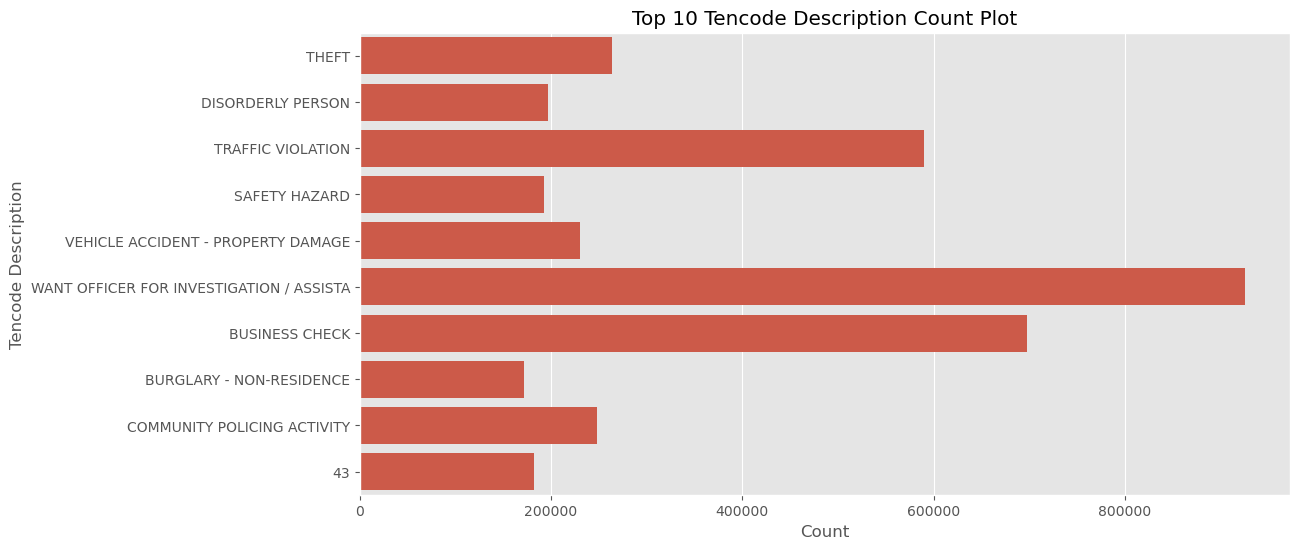

In [71]:
tcd_counts = df['Tencode_Description'].value_counts()
top_10_tcd = tcd_counts.head(10).index
TCD_top_10_df = df[df['Tencode_Description'].isin(top_10_tcd)]

plt.figure(figsize=(12,6))
TCD_count = sns.countplot(y='Tencode_Description', data=TCD_top_10_df)
TCD_count = plt.xlabel('Count')
TCD_count = plt.ylabel('Tencode Description')
TCD_count = plt.title('Top 10 Tencode Description Count Plot')

## It seems the most frequent call types are non-violent calls including wanting an officer for investigation/assistance, business check, and traffic violations. This would show that we can allocate more senior officers to respond to more serious offenses, while sending more inexperienced officers and even those still in the academy to respond to more of these calls.

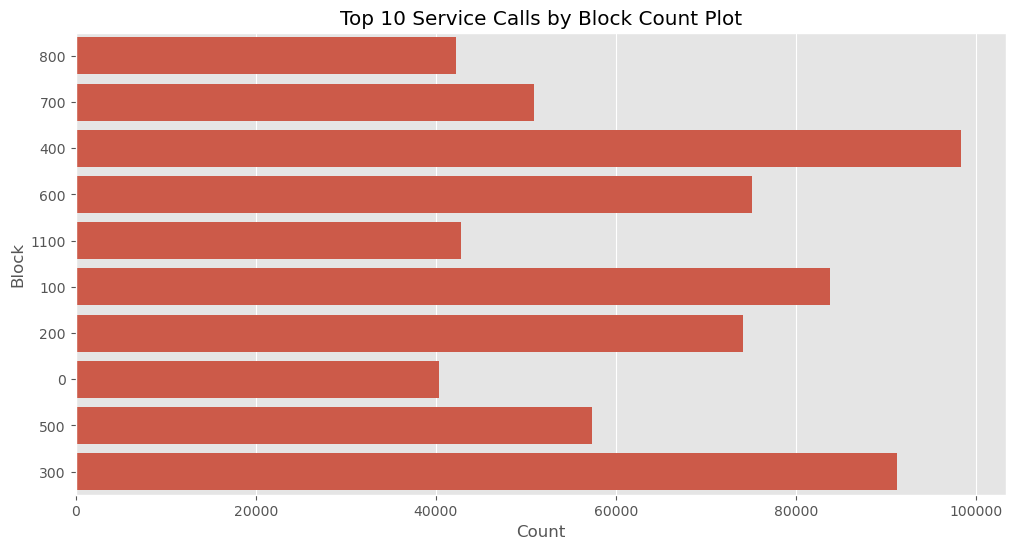

In [72]:
not_unknown = df[df['Block'] != '999999']

block_counts = not_unknown['Block'].value_counts()
top_10_blocks = block_counts.head(10).index
blocks_top_10_df = df[df['Block'].isin(top_10_blocks)]

plt.figure(figsize=(12,6))
block_count = sns.countplot(y='Block', data=blocks_top_10_df)
block_count = plt.xlabel('Count')
block_count = plt.ylabel('Block')
block_count = plt.title('Top 10 Service Calls by Block Count Plot')
block_count = plt.ticklabel_format(style='plain', axis='x')

## Interestingly, it is almost exlusively the sub 1000 blocks represented in the top 10 blocks with the most service calls. With the most calls so highly concentrated, it will make it easier to allocate officers and resources in a central location to be more readily available.

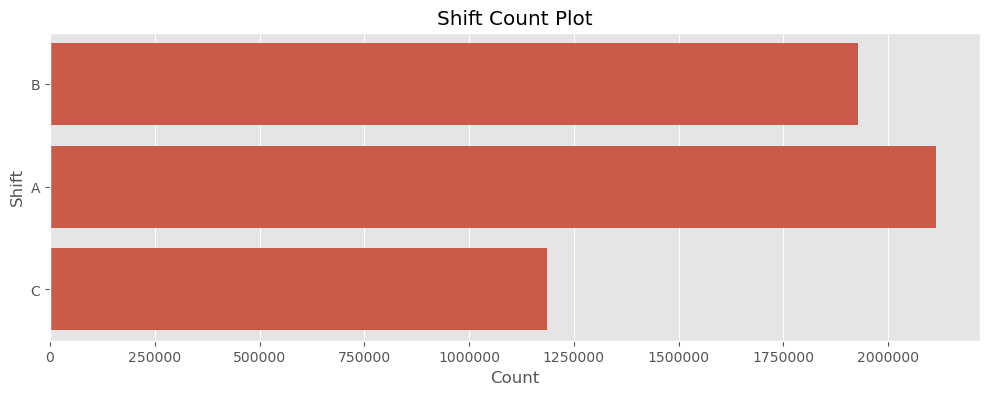

In [73]:
# Shift Count Plot
plt.figure(figsize=(12,4))
shift_count = sns.countplot(y='Shift', data=df)
shift_count = plt.xlabel('Count')
shift_count = plt.ylabel('Shift')
shift_count = plt.title('Shift Count Plot')
shift_count = plt.ticklabel_format(style='plain', axis='x')

## This will be extremely useful to us in making staffing and scheduling decisions. C clearly has the lowest amount of calls so we may want to look at our staffing during that shift and compare it to the other two shifts to determine if we are utilizing our resources optimally.

In [74]:
#Extract features from datetime column
df['Year'] = df['Call_Received'].dt.year
df['Month'] = df['Call_Received'].dt.month
df['Day_of_Month'] = df['Call_Received'].dt.day
df['Day_of_Week'] = df['Call_Received'].dt.day_name()
df['Hour_of_Day'] = df['Call_Received'].dt.hour

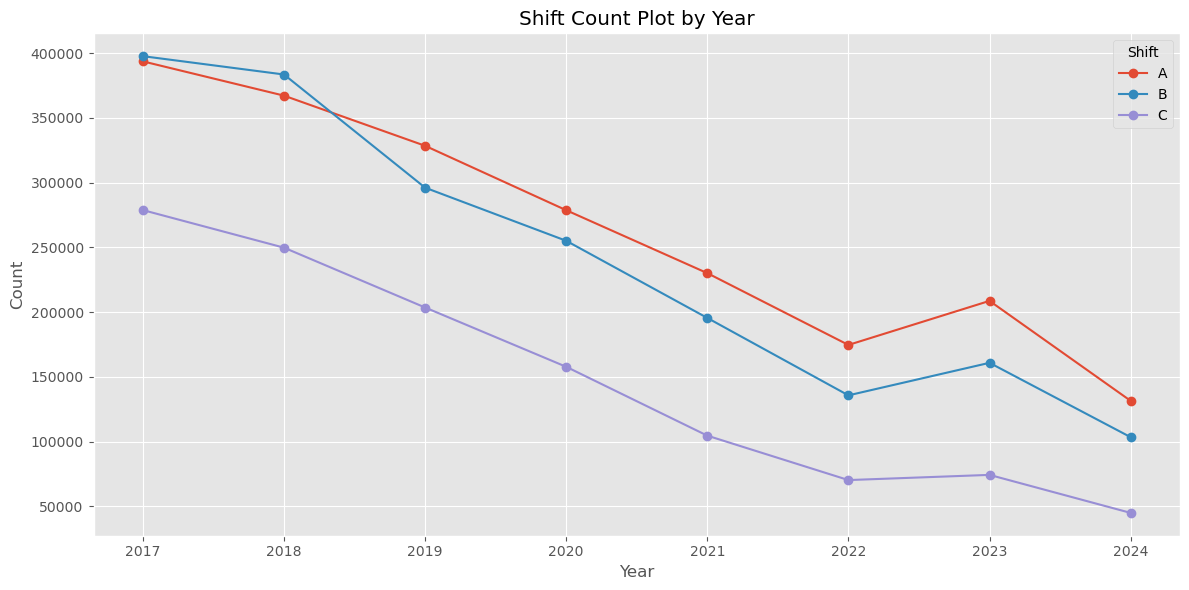

In [75]:
shift_counts = df.groupby(['Year', 'Shift']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
annual_shift_line = shift_counts.plot(kind='line', marker='o', ax=plt.gca())
annual_shift_line = plt.xlabel('Year')
annual_shift_line = plt.ylabel('Count')
annual_shift_line = plt.title('Shift Count Plot by Year')
annual_shift_line = plt.legend(title='Shift')
annual_shift_line = plt.tight_layout()

## Calls per shift have tracked down almost perfectly with each other over the last 7 years with two exceptions:
1) Shift B had the most service calls prior to 2019, being overtaken by Shift A in that year due to an abnormal drop in calls for Shift B.
2) 2023 showed an uptick in calls across all shifts, breaking from the downward trend of the prior years.

## Something to note is that 2024 data is incomplete as we are only 2/3 through the year. The downtrend following 2023 will not look like this at the end of the year. We may see a slight downtrend or possibly even a very small uptick after the year is complete and the data is collected.

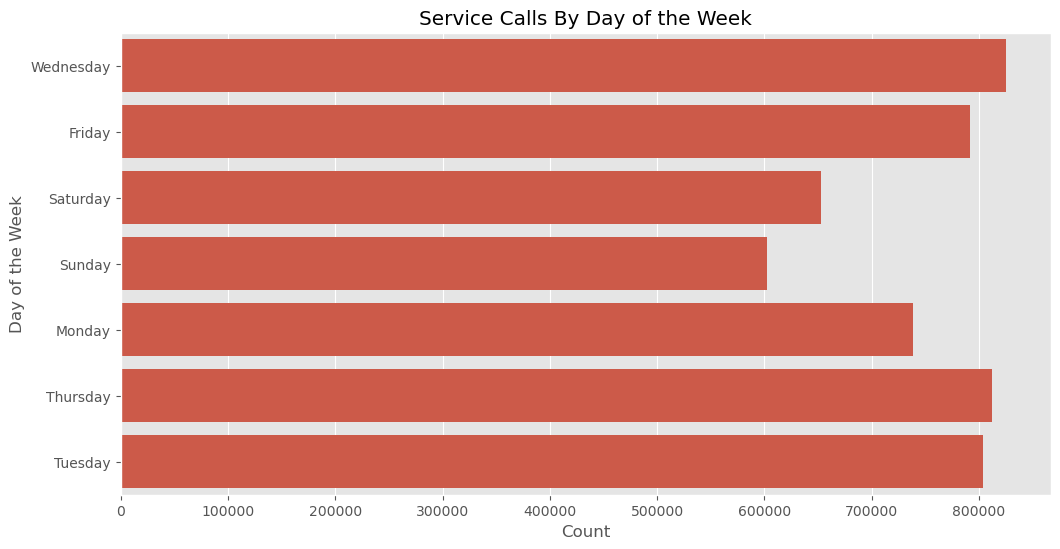

In [76]:
# Day of the week Count Plot
plt.figure(figsize=(12,6))
calls_count_day = sns.countplot(y='Day_of_Week', data=df)
calls_count_day = plt.xlabel('Count')
calls_count_day = plt.ylabel('Day of the Week')
calls_count_day = plt.title('Service Calls By Day of the Week')

## Very unexpectedly, Saturday and Sunday are the days with the fewest service calls. Intuitively, one would think that with most people off work on the weekends, you'd see more interactions which would lead to more service calls but that's not what the data shows. We'd want to confirm that our scheduling follow this trend.

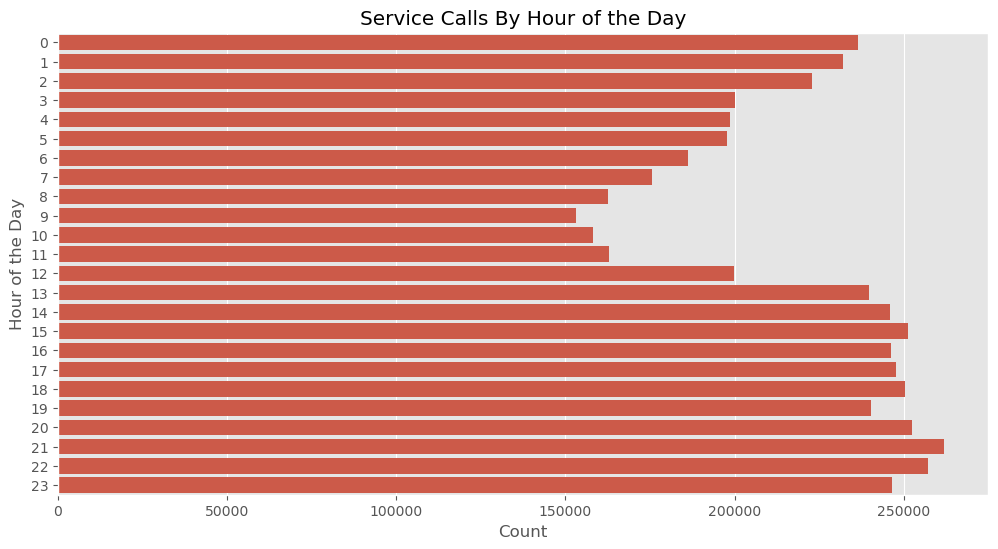

In [77]:
# Hour of the Day Count Plot
plt.figure(figsize=(12,6))
calls_count_day = sns.countplot(y='Hour_of_Day', data=df)
calls_count_day = plt.xlabel('Count')
calls_count_day = plt.ylabel('Hour of the Day')
calls_count_day = plt.title('Service Calls By Hour of the Day')

## This is more or less what I would expect to see. It may be useful to use this data to adjust shifts so that half of the low call period is in one shift and half is in the other so as to spread the workload out more evenly.

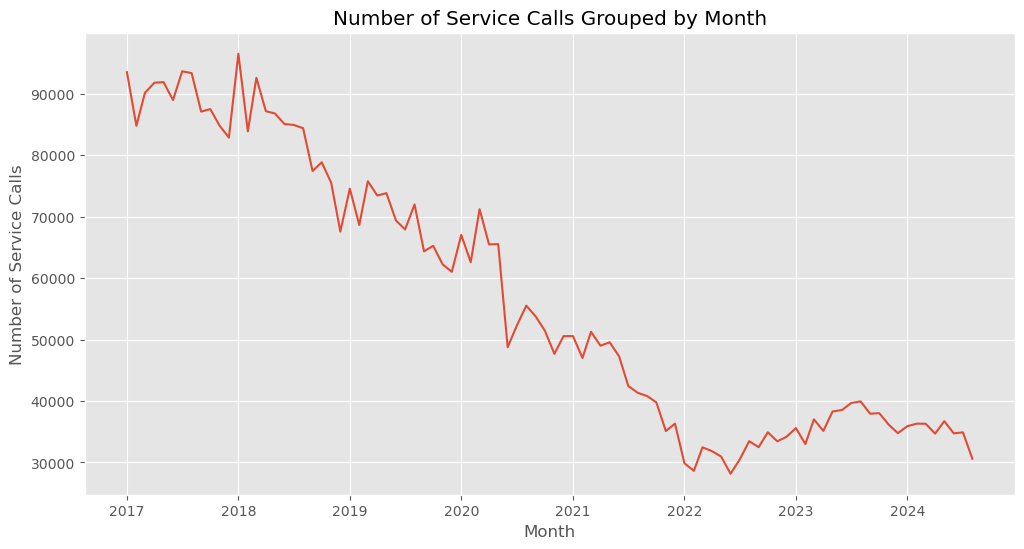

In [78]:
calls_per_month = df.groupby(df['Call_Received'].dt.to_period('M')).size()
calls_per_month.index = calls_per_month.index.to_timestamp()

plt.figure(figsize=(12, 6))
total_calls_month = plt.plot(calls_per_month.index, calls_per_month.values)
total_calls_month = plt.xlabel('Month')
total_calls_month = plt.ylabel('Number of Service Calls')
total_calls_month = plt.title('Number of Service Calls Grouped by Month')

## Before turning to forecasting future service calls, I wanted to take a quick look at the overall monthly trend. The peaks and valleys clearly follow certain economic points in time. As a general rule, one can assume, when the economy is doing better, serviceclls go down:
1) Peak in 2018 when interest rates were rising rapidly and the economy started to cool.
2) Peak in early 2020 before the stay at home order when people started hurting financially, then a steep dropoff when people were paid to stay at home
3) Gradual increase starting in 2022 tracks with the rise of inflation and people doing generally worse off economically.

# Forecasting future Service Calls

## As we can see from our last plot, our data is clearly not stationary. The Prophet model handles non-stationary data very well so taking the diff of our Calls_Received to create stationarity is not necessary. Prophet also works directly with the original scale of the data. There’s no need to scale the data before fitting the model in this case.

In [79]:
prophet_df = df.groupby(df['Call_Received'].dt.date).size().reset_index(name='y')

In [80]:
prophet_df['Call_Received'] = pd.to_datetime(prophet_df['Call_Received'])
prophet_df.rename(columns={'Call_Received': 'ds'}, inplace=True)

In [81]:
prophet_df['Year'] = prophet_df['ds'].dt.year
prophet_df['Month'] = prophet_df['ds'].dt.month
prophet_df['Day'] = prophet_df['ds'].dt.day

In [82]:
for lag in range(1,8):
    prophet_df[f'Lag_{lag}'] = prophet_df['y'].shift(lag)

In [83]:
prophet_df.dropna(inplace=True)

In [84]:
prophet_df

,ds,y,Year,Month,Day,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7
7,2017-01-08,2319,2017,1,8,2601.0,3301.0,3214.0,3298.0,3030.0,2636.0,1503.0
8,2017-01-09,2744,2017,1,9,2319.0,2601.0,3301.0,3214.0,3298.0,3030.0,2636.0
9,2017-01-10,3285,2017,1,10,2744.0,2319.0,2601.0,3301.0,3214.0,3298.0,3030.0
10,2017-01-11,3373,2017,1,11,3285.0,2744.0,2319.0,2601.0,3301.0,3214.0,3298.0
11,2017-01-12,3480,2017,1,12,3373.0,3285.0,2744.0,2319.0,2601.0,3301.0,3214.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2791,2024-08-23,1282,2024,8,23,1296.0,1327.0,1213.0,1199.0,921.0,1034.0,1193.0
2792,2024-08-24,911,2024,8,24,1282.0,1296.0,1327.0,1213.0,1199.0,921.0,1034.0
2793,2024-08-25,921,2024,8,25,911.0,1282.0,1296.0,1327.0,1213.0,1199.0,921.0
2794,2024-08-26,1275,2024,8,26,921.0,911.0,1282.0,1296.0,1327.0,1213.0,1199.0


In [85]:
train_size = len(prophet_df) - 365

train_df_p = prophet_df.iloc[:train_size]
test_df_p = prophet_df.iloc[train_size:]

In [86]:
train_df_p

,ds,y,Year,Month,Day,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7
7,2017-01-08,2319,2017,1,8,2601.0,3301.0,3214.0,3298.0,3030.0,2636.0,1503.0
8,2017-01-09,2744,2017,1,9,2319.0,2601.0,3301.0,3214.0,3298.0,3030.0,2636.0
9,2017-01-10,3285,2017,1,10,2744.0,2319.0,2601.0,3301.0,3214.0,3298.0,3030.0
10,2017-01-11,3373,2017,1,11,3285.0,2744.0,2319.0,2601.0,3301.0,3214.0,3298.0
11,2017-01-12,3480,2017,1,12,3373.0,3285.0,2744.0,2319.0,2601.0,3301.0,3214.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2426,2023-08-24,1258,2023,8,24,1401.0,1256.0,1211.0,1053.0,1089.0,1443.0,1358.0
2427,2023-08-25,1378,2023,8,25,1258.0,1401.0,1256.0,1211.0,1053.0,1089.0,1443.0
2428,2023-08-26,1005,2023,8,26,1378.0,1258.0,1401.0,1256.0,1211.0,1053.0,1089.0
2429,2023-08-27,993,2023,8,27,1005.0,1378.0,1258.0,1401.0,1256.0,1211.0,1053.0


In [87]:
test_df_p

,ds,y,Year,Month,Day,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7
2431,2023-08-29,1316,2023,8,29,1245.0,993.0,1005.0,1378.0,1258.0,1401.0,1256.0
2432,2023-08-30,1480,2023,8,30,1316.0,1245.0,993.0,1005.0,1378.0,1258.0,1401.0
2433,2023-08-31,1386,2023,8,31,1480.0,1316.0,1245.0,993.0,1005.0,1378.0,1258.0
2434,2023-09-01,1240,2023,9,1,1386.0,1480.0,1316.0,1245.0,993.0,1005.0,1378.0
2435,2023-09-02,1026,2023,9,2,1240.0,1386.0,1480.0,1316.0,1245.0,993.0,1005.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2791,2024-08-23,1282,2024,8,23,1296.0,1327.0,1213.0,1199.0,921.0,1034.0,1193.0
2792,2024-08-24,911,2024,8,24,1282.0,1296.0,1327.0,1213.0,1199.0,921.0,1034.0
2793,2024-08-25,921,2024,8,25,911.0,1282.0,1296.0,1327.0,1213.0,1199.0,921.0
2794,2024-08-26,1275,2024,8,26,921.0,911.0,1282.0,1296.0,1327.0,1213.0,1199.0


In [88]:
# Looping over the Prophet model with different parameters below generates multiple messages every time
# the model starts and stops with new parameters. We'll want to suppress those messages so our notebook
# is not extensively long due to these start/stop messages.

import logging
import logging.config

# Define a custom logging configuration to suppress logs
logging.config.dictConfig({
    'version': 1,
    'disable_existing_loggers': True,
    'formatters': {
        'default': {
            'format': '%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        },
    },
    'handlers': {
        'null': {
            'class': 'logging.NullHandler',
        },
    },
    'loggers': {
        'cmdstanpy': {
            'handlers': ['null'],
            'level': 'CRITICAL',
        },
        'prophet': {
            'handlers': ['null'],
            'level': 'CRITICAL',
        },
    },
})

In [89]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 1],
    'seasonality_prior_scale': [0.01, 0.1, 1, 10],
    'holidays_prior_scale': [0.01, 0.1, 1, 10]}

In [90]:
def evaluate_model(params, df, horizon='365 days'):
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'])
    
    model.fit(df)
    future = model.make_future_dataframe(periods=len(test_df_p))
    forecast = model.predict(future)
    
    cv_results = cross_validation(model, initial='365 days', period='30 days', horizon=horizon)
    
    metrics = performance_metrics(cv_results)
    
    return metrics['rmse'].mean()

In [91]:
best_score = np.inf
best_params = None

for params in ParameterGrid(param_grid):
    score = evaluate_model(params, train_df_p)
    print(f"Params: {params} - RMSE: {score}")
    
    if score < best_score:
        best_score = score
        best_params = params

print(f"Best parameters: {best_params} with RMSE: {best_score}")

  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01} - RMSE: 330.8211671639061


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1} - RMSE: 328.9949273290841


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 1} - RMSE: 342.7432343666117


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 10} - RMSE: 346.1389563033603


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.01} - RMSE: 330.8211671639061


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.1} - RMSE: 328.9949273290841


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 1} - RMSE: 342.7432343666117


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 10} - RMSE: 346.1389563033603


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 0.01} - RMSE: 330.8211671639061


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 0.1} - RMSE: 328.9949273290841


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 1} - RMSE: 342.7432343666117


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 10} - RMSE: 346.1389563033603


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.01} - RMSE: 330.8211671639061


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.1} - RMSE: 328.9949273290841


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 1} - RMSE: 342.7432343666117


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 10} - RMSE: 346.1389563033603


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01} - RMSE: 306.53330326103014


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1} - RMSE: 314.76086729584637


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 1} - RMSE: 314.28918272331845


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 10} - RMSE: 314.84187291746434


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.01} - RMSE: 306.53330326103014


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.1} - RMSE: 314.76086729584637


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 1} - RMSE: 314.28918272331845


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 10} - RMSE: 314.84187291746434


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 0.01} - RMSE: 306.53330326103014


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 0.1} - RMSE: 314.76086729584637


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 1} - RMSE: 314.28918272331845


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 10} - RMSE: 314.84187291746434


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.01} - RMSE: 306.53330326103014


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.1} - RMSE: 314.76086729584637


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 1} - RMSE: 314.28918272331845


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 10} - RMSE: 314.84187291746434


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01} - RMSE: 337.0018421069594


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1} - RMSE: 341.3030699270134


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 1} - RMSE: 341.44359907328817


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 10} - RMSE: 341.2803630574585


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.01} - RMSE: 337.0018421069594


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.1} - RMSE: 341.3030699270134


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 1} - RMSE: 341.44359907328817


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 10} - RMSE: 341.2803630574585


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 0.01} - RMSE: 337.0018421069594


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 0.1} - RMSE: 341.3030699270134


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 1} - RMSE: 341.44359907328817


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 10} - RMSE: 341.2803630574585


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.01} - RMSE: 337.0018421069594


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.1} - RMSE: 341.3030699270134


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 1} - RMSE: 341.44359907328817


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 10} - RMSE: 341.2803630574585


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01} - RMSE: 412.3109459296496


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1} - RMSE: 480.17239054600435


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 1} - RMSE: 460.3472433684035


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 10} - RMSE: 464.11368312931313


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.01} - RMSE: 412.3109459296496


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.1} - RMSE: 480.17239054600435


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 1} - RMSE: 460.3472433684035


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 10} - RMSE: 464.11368312931313


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 1, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 0.01} - RMSE: 412.3109459296496


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 1, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 0.1} - RMSE: 480.17239054600435


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 1, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 1} - RMSE: 460.3472433684035


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 1, 'holidays_prior_scale': 1, 'seasonality_prior_scale': 10} - RMSE: 464.11368312931313


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.01} - RMSE: 412.3109459296496


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.1} - RMSE: 480.17239054600435


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 1} - RMSE: 460.3472433684035


  0%|          | 0/57 [00:00<?, ?it/s]

Params: {'changepoint_prior_scale': 1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 10} - RMSE: 464.11368312931313
Best parameters: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01} with RMSE: 306.53330326103014


In [92]:
best_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'])

best_model.fit(train_df_p)

future = best_model.make_future_dataframe(periods=len(test_df_p), include_history=False)
forecast = best_model.predict(future)
print(f"RMSE: {best_score}")

RMSE: 306.53330326103014


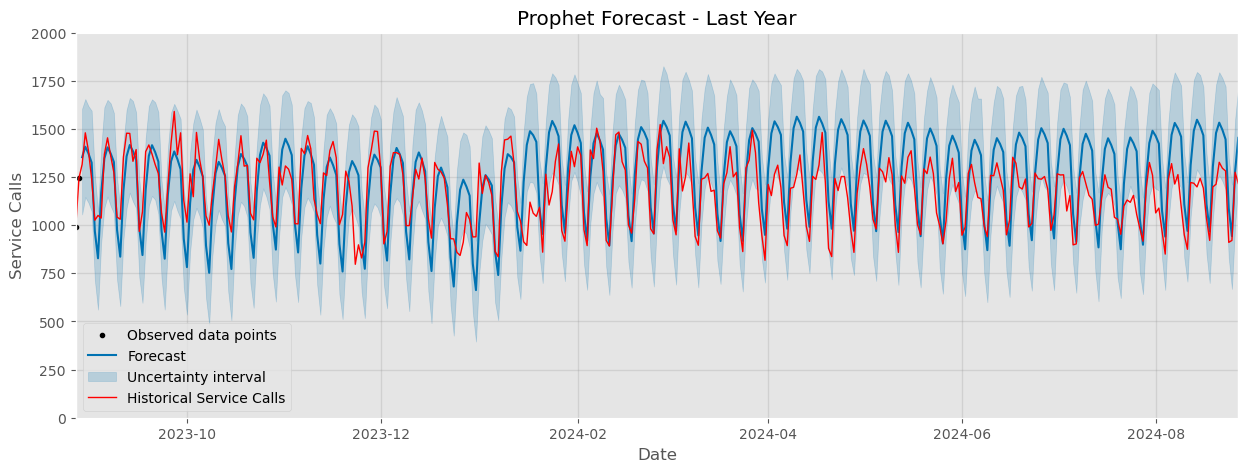

In [93]:
last_year = prophet_df[prophet_df['ds'] >= prophet_df['ds'].max() - pd.DateOffset(years=1)]

fig, ax = plt.subplots(figsize=(15, 5))
fig = best_model.plot(forecast, ax=ax)

ax.plot(last_year['ds'], last_year['y'], label='Historical Service Calls', color='red', linewidth=1)

ax.set_xlim([last_year['ds'].min(), prophet_df['ds'].max()])
ax.set_ylim([0, 2000])

ax.legend()
ax.set_title('Prophet Forecast - Last Year')
plt.xlabel('Date')
plt.ylabel('Service Calls')
plt.show()

In [94]:
best_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'])

best_model.fit(prophet_df)

future = best_model.make_future_dataframe(periods=len(test_df_p), include_history=False)
future_forecast = best_model.predict(future)

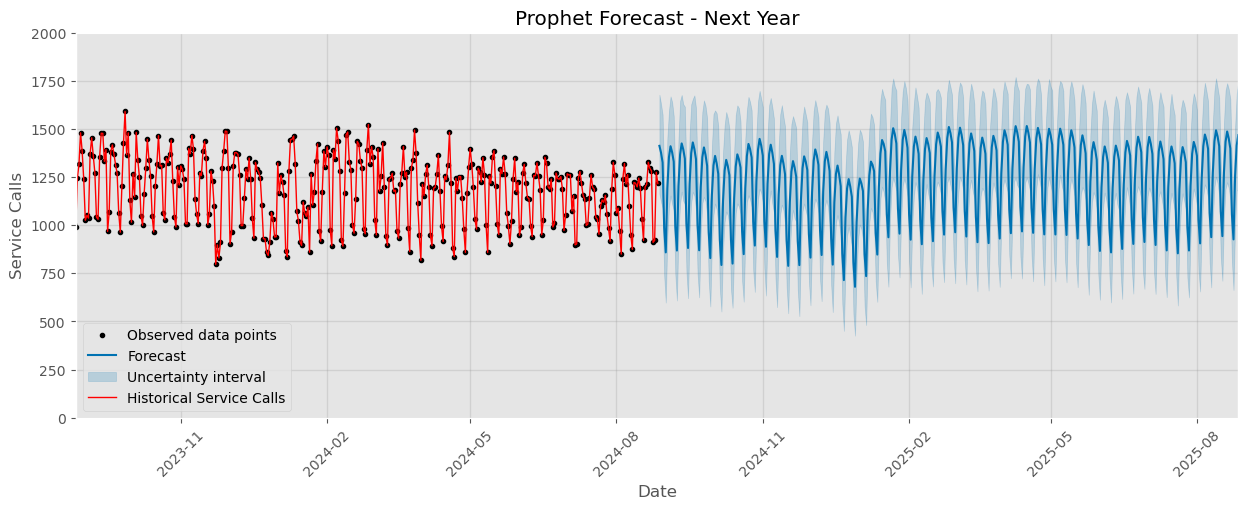

In [97]:
last_year = prophet_df[prophet_df['ds'] >= prophet_df['ds'].max() - pd.DateOffset(years=1)]

fig, ax = plt.subplots(figsize=(15,5))
fig = best_model.plot(future_forecast, ax=ax)

ax.plot(last_year['ds'], last_year['y'], label='Historical Service Calls', color='red', linewidth=1)

ax.set_xlim([last_year['ds'].min(), future_forecast['ds'].max()])
ax.set_ylim([0, 2000])

ax.legend()
ax.set_title('Prophet Forecast - Next Year')
plt.xlabel('Date')
plt.ylabel('Service Calls')
plt.xticks(rotation=45)
plt.show()

In [98]:
future_forecast[['ds','yhat']]

,ds,yhat
0,2024-08-28,1412.364879
1,2024-08-29,1377.413264
2,2024-08-30,1326.259866
3,2024-08-31,986.826923
4,2024-09-01,858.922591
...,...,...
360,2025-08-23,1056.856467
361,2025-08-24,926.347349
362,2025-08-25,1257.050628
363,2025-08-26,1414.466453
